# Day 15: Neural Network Basics

**Week 3: Deep Learning Essentials**

Welcome to the beginning of your deep learning journey. Today, we'll build a solid foundation by understanding how neural networks actually work focusing on intuition and practical implementation rather than heavy mathematics.

---
**Goal**: Build a strong foundational understanding of neural networks by learning how they work internally, implementing one from scratch, and knowing when to use them in real-world projects.

## Learning Objectives

By the end of this notebook, you will:

- Understand what neural networks are and why they're powerful
- Grasp the intuition behind forward propagation and backpropagation
- Build a neural network from scratch using NumPy
- Implement a practical example with scikit-learn's MLPClassifier
- Know when to use neural networks vs traditional ML algorithms

---


## 1. Concept Overview

### What is a Neural Network?

A neural network is a computing system inspired by biological neural networks. It's essentially a function approximator that can learn complex patterns from data.

**Think of it this way:**
- Traditional ML algorithms: You manually engineer features, the model finds simple patterns
- Neural Networks: The model learns both the features AND the patterns automatically

### Architecture Components

#### 1. **Neurons (Nodes)**
The basic computational unit. Each neuron:
- Receives inputs (from previous layer or raw data)
- Applies weights to these inputs
- Adds a bias term
- Passes through an activation function

```
Output = Activation(Σ(weights × inputs) + bias)
```

#### 2. **Layers**

- **Input Layer**: Receives raw features (no computation happens here)
- **Hidden Layers**: Where the magic happens—learns representations
- **Output Layer**: Produces final predictions

```
Input Layer → Hidden Layer(s) → Output Layer
   [X]     →      [H]       →      [Y]
```

![alt text](<Images/Neural Networks.JPG>)

#### 3. **Weights and Biases**

- **Weights**: Determine the strength of connections between neurons
- **Biases**: Allow the model to shift the activation function
- Both are **learnable parameters** that get updated during training

#### 4. **Activation Functions**

These introduce non-linearity, allowing the network to learn complex patterns.

| Function | Formula | Use Case |
|----------|---------|----------|
| **Sigmoid** | σ(x) = 1/(1+e^(-x)) | Binary classification (output layer) |
| **ReLU** | f(x) = max(0, x) | Hidden layers (most common) |
| **Tanh** | f(x) = tanh(x) | Hidden layers (centered around 0) |
| **Softmax** | f(x_i) = e^(x_i)/Σe^(x_j) | Multi-class classification (output) |

**Why ReLU is popular:**
- Computationally efficient
- Helps avoid vanishing gradient problem
- Works well in practice

---


### Forward Propagation: The Prediction Phase

**Intuition**: Data flows forward through the network, layer by layer, until we get a prediction.

**Process:**

1. Start with input features
2. For each layer:
   - Multiply inputs by weights
   - Add bias
   - Apply activation function
   - Pass result to next layer
3. Final layer outputs prediction

**Example (2-layer network):**

```
Input: X (features)
Layer 1: H = activation(X × W1 + b1)
Layer 2: Y = activation(H × W2 + b2)
Output: Y (prediction)
```

---


### Backpropagation: The Learning Phase

**Intuition**: After making a prediction, we calculate how wrong we were and adjust weights to be less wrong next time.

**The Big Idea:**
- Calculate error at output layer
- Propagate this error backwards through the network
- Update each weight based on how much it contributed to the error

**Key Concept: Gradient Descent**

Think of it as rolling a ball down a hill to find the lowest point:
- The hill is our loss function (error)
- We want to reach the valley (minimum error)
- We take steps in the direction of steepest descent

**Update Rule:**
```
new_weight = old_weight - learning_rate × gradient
```

**Learning Rate**: How big of steps we take
- Too large: Might overshoot the minimum
- Too small: Training takes forever
- Typical values: 0.001 to 0.1

---


### Loss Functions

How we measure "how wrong" our predictions are:

| Task | Loss Function | Description |
|------|---------------|-------------|
| **Regression** | Mean Squared Error (MSE) | Average of squared differences |
| **Binary Classification** | Binary Cross-Entropy | Measures probability distribution difference |
| **Multi-class Classification** | Categorical Cross-Entropy | Extension of binary cross-entropy |

---


### When to Use Neural Networks

**Use Neural Networks When:**
- You have large amounts of data (thousands+ samples)
- The problem is highly complex with non-linear patterns
- You're working with unstructured data (images, text, audio)
- Feature engineering is difficult or unclear

**Stick with Traditional ML When:**
- You have limited data (< 1000 samples)
- The problem is relatively simple
- Interpretability is crucial
- You need quick training and deployment

**Real-World Applications:**
- Image recognition (facial recognition, medical imaging)
- Natural language processing (chatbots, translation)
- Recommendation systems (Netflix, Amazon)
- Fraud detection in financial transactions
- Autonomous vehicles

---


## 2. Code Implementation

Let's build our understanding through code. We'll start simple and progressively add complexity.


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_circles, load_breast_cancer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


### 2.1 Building a Neural Network from Scratch

Let's implement a simple 2-layer neural network to understand the core mechanics.


In [2]:
class SimpleNeuralNetwork:
    """
    A simple 2-layer neural network for binary classification.
    Architecture: Input → Hidden Layer → Output Layer
    """
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initialize network parameters.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        hidden_size : int
            Number of neurons in hidden layer
        output_size : int
            Number of output neurons (1 for binary classification)
        learning_rate : float
            Learning rate for gradient descent
        """
        # Initialize weights with small random values (Xavier-like initialization)
        # Multiply by 0.01 to keep initial values small, preventing saturation
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))  # Biases can start at zero
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        
        self.learning_rate = learning_rate
        self.losses = []  # Track loss history for visualization
    
    def sigmoid(self, z):
        """
        Sigmoid activation function: maps any value to range (0, 1)
        Used for binary classification and introducing non-linearity
        """
        # Clip values to prevent overflow in exp() - critical for numerical stability
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def sigmoid_derivative(self, z):
        """
        Derivative of sigmoid function for backpropagation
        Note: z here is already sigmoid(x), not the raw input
        Formula: sigmoid'(x) = sigmoid(x) * (1 - sigmoid(x))
        """
        return z * (1 - z)
    
    def forward_propagation(self, X):
        """
        Forward pass through the network - this is the prediction phase.
        Data flows: Input → Hidden Layer → Output Layer
        
        Returns:
        --------
        A2 : predictions from output layer (probabilities between 0 and 1)
        cache : intermediate values needed for backpropagation
        """
        # Layer 1: Input → Hidden
        # Z1 = weighted sum + bias (linear transformation)
        Z1 = np.dot(X, self.W1) + self.b1
        # A1 = activated output (introduces non-linearity)
        A1 = self.sigmoid(Z1)
        
        # Layer 2: Hidden → Output
        # Same process: linear transformation then activation
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.sigmoid(Z2)  # Final output: probability of class 1
        
        # Cache activations for use in backpropagation
        cache = {'A1': A1, 'A2': A2}
        return A2, cache
    
    def compute_loss(self, y_true, y_pred):
        """
        Binary cross-entropy loss - measures prediction quality
        Lower loss = better predictions
        
        Formula: -mean(y*log(pred) + (1-y)*log(1-pred))
        """
        m = y_true.shape[0]  # Number of training examples
        
        # Add small epsilon to prevent log(0) which would give -infinity
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Cross-entropy: penalizes confident wrong predictions heavily
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def backward_propagation(self, X, y, cache):
        """
        Backward pass: compute gradients and update weights.
        This is where the learning happens! Uses chain rule from calculus.
        
        Process:
        1. Calculate how wrong we were (error at output)
        2. Propagate error backwards through the network
        3. Calculate how much each weight contributed to error
        4. Update weights to reduce error
        """
        m = X.shape[0]  # Number of training examples
        A1 = cache['A1']  # Hidden layer activations
        A2 = cache['A2']  # Output layer activations (predictions)
        
        # --- Output Layer Gradients ---
        # dZ2: error at output layer (how far off were our predictions?)
        # For binary cross-entropy + sigmoid, derivative simplifies to (prediction - truth)
        dZ2 = A2 - y
        
        # dW2: gradient for W2 weights (how much does each weight contribute to error?)
        # Chain rule: dLoss/dW2 = dLoss/dZ2 * dZ2/dW2
        dW2 = np.dot(A1.T, dZ2) / m
        
        # db2: gradient for b2 bias (average error across all examples)
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # --- Hidden Layer Gradients ---
        # dZ1: propagate error back to hidden layer
        # Multiply by sigmoid derivative to account for activation function
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(A1)
        
        # dW1: gradient for W1 weights (how input features affect hidden layer)
        dW1 = np.dot(X.T, dZ1) / m
        
        # db1: gradient for b1 bias
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        # --- Gradient Descent Update ---
        # Move weights in opposite direction of gradient (downhill on loss surface)
        # Learning rate controls step size
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network using gradient descent.
        Each epoch = one complete pass through all training data.
        
        Parameters:
        -----------
        X : array-like
            Training features
        y : array-like
            Training labels
        epochs : int
            Number of training iterations (full passes through data)
        verbose : bool
            Whether to print progress every 100 epochs
        """
        for epoch in range(epochs):
            # Forward pass: make predictions
            predictions, cache = self.forward_propagation(X)
            
            # Compute loss: measure how wrong we are
            loss = self.compute_loss(y, predictions)
            self.losses.append(loss)  # Save for plotting later
            
            # Backward pass: learn from mistakes
            self.backward_propagation(X, y, cache)
            
            # Print progress periodically
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
    
    def predict(self, X):
        """
        Make predictions on new data
        Returns binary predictions (0 or 1) using 0.5 threshold
        """
        predictions, _ = self.forward_propagation(X)
        # Convert probabilities to binary predictions: >0.5 → class 1, ≤0.5 → class 0
        return (predictions > 0.5).astype(int)

print("SimpleNeuralNetwork class defined successfully!")


SimpleNeuralNetwork class defined successfully!


### 2.2 Test Our Neural Network

Let's create a non-linear dataset and see our network in action.


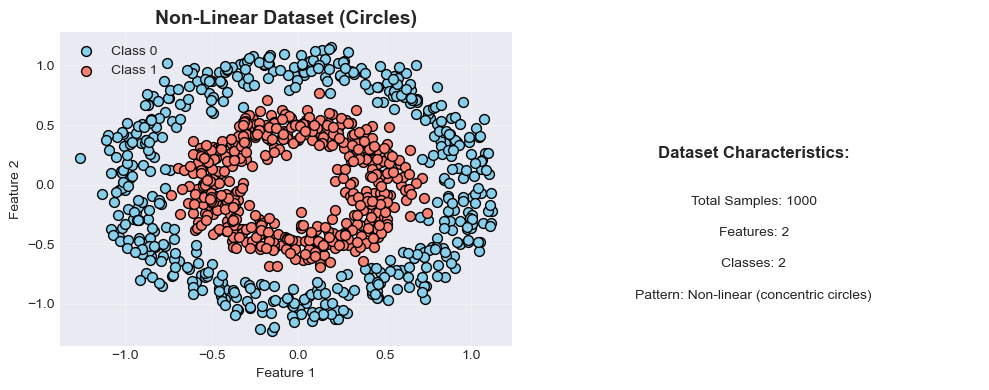

Training set: 800 samples
Test set: 200 samples


In [3]:
# Generate a non-linear dataset (circles) - perfect for testing neural networks!
# Circles dataset: inner circle = class 0, outer circle = class 1
# This pattern is NOT linearly separable, so traditional models like logistic regression will fail
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
y = y.reshape(-1, 1)  # Reshape from (1000,) to (1000, 1) for our network

# Split into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the dataset
plt.figure(figsize=(10, 4))

# Left plot: scatter plot showing the circular pattern
plt.subplot(1, 2, 1)
plt.scatter(X[y.ravel()==0, 0], X[y.ravel()==0, 1], c='skyblue', label='Class 0', edgecolors='k', s=50)
plt.scatter(X[y.ravel()==1, 0], X[y.ravel()==1, 1], c='salmon', label='Class 1', edgecolors='k', s=50)
plt.title('Non-Linear Dataset (Circles)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Right plot: dataset statistics
plt.subplot(1, 2, 2)
plt.text(0.5, 0.6, 'Dataset Characteristics:', fontsize=12, fontweight='bold', 
         ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.45, f'Total Samples: {len(X)}', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.35, f'Features: {X.shape[1]}', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.25, f'Classes: 2', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.15, 'Pattern: Non-linear (concentric circles)', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


In [4]:
# Initialize and train our neural network
# Architecture: 2 inputs → 10 hidden neurons → 1 output
# Learning rate of 0.5 is relatively high, allowing faster convergence on this simple problem
nn = SimpleNeuralNetwork(input_size=2, hidden_size=10, output_size=1, learning_rate=0.5)

print("Training Neural Network...\n")
# Train for 1000 epochs - watch the loss decrease as the network learns!
nn.train(X_train, y_train, epochs=1000, verbose=True)


Training Neural Network...

Epoch 0/1000, Loss: 0.6932
Epoch 100/1000, Loss: 0.6931
Epoch 200/1000, Loss: 0.6931
Epoch 300/1000, Loss: 0.6931
Epoch 400/1000, Loss: 0.6931
Epoch 500/1000, Loss: 0.6931
Epoch 600/1000, Loss: 0.6931
Epoch 700/1000, Loss: 0.6931
Epoch 800/1000, Loss: 0.6931
Epoch 900/1000, Loss: 0.6931



Training Accuracy: 0.4913
Test Accuracy: 0.4600


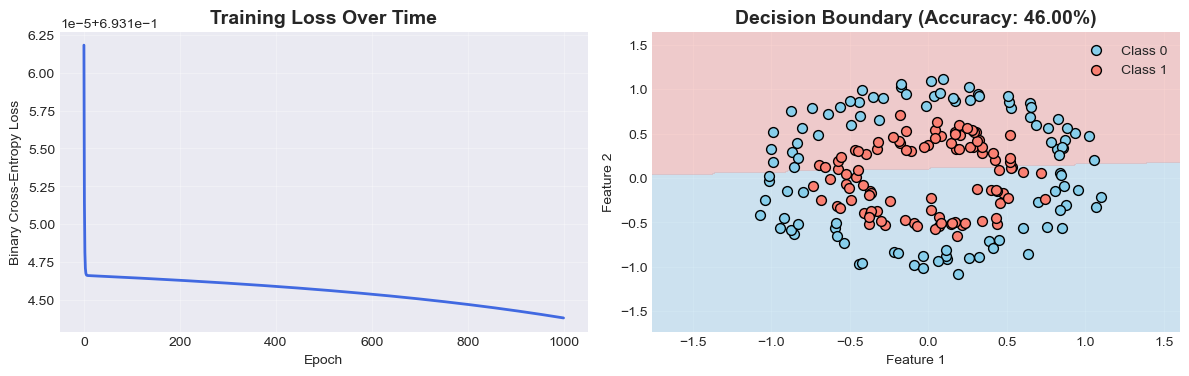

In [5]:
# Evaluate the model on both training and test sets
train_predictions = nn.predict(X_train)
test_predictions = nn.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training loss and decision boundary
plt.figure(figsize=(12, 4))

# Left plot: Training loss curve
plt.subplot(1, 2, 1)
plt.plot(nn.losses, color='royalblue', linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

# Right plot: Decision boundary visualization
plt.subplot(1, 2, 2)
# Create a mesh grid covering the entire feature space
h = 0.02  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions for every point in the mesh to visualize the decision boundary
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary (regions where the model predicts each class)
plt.contourf(xx, yy, Z, alpha=0.3, levels=1, colors=['skyblue', 'salmon'])

# Overlay the actual test data points
plt.scatter(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], 
            c='skyblue', edgecolors='k', s=50, label='Class 0')
plt.scatter(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], 
            c='salmon', edgecolors='k', s=50, label='Class 1')
plt.title(f'Decision Boundary (Accuracy: {test_accuracy:.2%})', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Key Observations:

1. **Loss Decreases**: The network learns by reducing error over time
2. **Non-Linear Boundaries**: Unlike logistic regression, neural networks can learn complex decision boundaries
3. **Hidden Layer Magic**: The hidden layer creates representations that make the problem linearly separable

---


### 2.3 Practical Implementation with Scikit-learn

Now let's use scikit-learn's production-ready implementation on a real dataset.


In [6]:
# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

print("Dataset: Breast Cancer Wisconsin")
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(np.unique(y))} (Malignant, Benign)")
print(f"\nFeature names: {data.feature_names[:5]}... (showing first 5)")


Dataset: Breast Cancer Wisconsin
Samples: 569
Features: 30
Classes: 2 (Malignant, Benign)

Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (showing first 5)


In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# IMPORTANT: Always scale features for neural networks!
# StandardScaler transforms features to have mean=0 and std=1
# This ensures all features are on the same scale, which is critical for:
# 1. Faster gradient descent convergence
# 2. Preventing features with larger magnitudes from dominating
# 3. Numerical stability during training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
X_test_scaled = scaler.transform(X_test)        # Transform test data using training stats

print("Data preprocessed successfully!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


Data preprocessed successfully!
Training set: (455, 30)
Test set: (114, 30)


#### Why Scaling is Critical for Neural Networks

Neural networks are sensitive to feature scales because:
- Gradient descent converges faster with normalized features
- Prevents one feature from dominating others
- Helps avoid numerical instability


In [8]:
# Create MLPClassifier (Multi-Layer Perceptron) - scikit-learn's production-ready neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers: 64 neurons → 32 neurons
                                   # Rule of thumb: start with 2-3x input size, then decrease
    
    activation='relu',             # ReLU activation for hidden layers
                                   # ReLU is the go-to choice: fast, effective, avoids vanishing gradients
    
    solver='adam',                 # Adam optimizer: adaptive learning rate, works well by default
                                   # Alternatives: 'sgd' (basic), 'lbfgs' (small datasets)
    
    max_iter=500,                  # Maximum training iterations (epochs)
    
    random_state=42,               # For reproducible results
    
    learning_rate_init=0.001,      # Initial learning rate (Adam will adapt this)
                                   # Typical range: 0.0001 to 0.01
    
    early_stopping=True,           # Stop training if validation score stops improving
                                   # Prevents overfitting and saves time
    
    validation_fraction=0.1,       # Use 10% of training data for validation monitoring
    
    n_iter_no_change=10,           # Patience: stop if no improvement for 10 consecutive epochs
    
    verbose=False                  # Set to True to see detailed training progress
)

print("Training Multi-Layer Perceptron...\n")
# Training happens here - Adam optimizer adjusts weights to minimize loss
mlp.fit(X_train_scaled, y_train)

print(f"Training completed in {mlp.n_iter_} iterations")
print(f"Final loss: {mlp.loss_:.4f}")


Training Multi-Layer Perceptron...

Training completed in 28 iterations
Final loss: 0.0830


In [9]:
# Make predictions
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\nClassification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=data.target_names))


Model Performance:
Training Accuracy: 0.9604
Test Accuracy: 0.9737

Classification Report:

              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        43
      benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



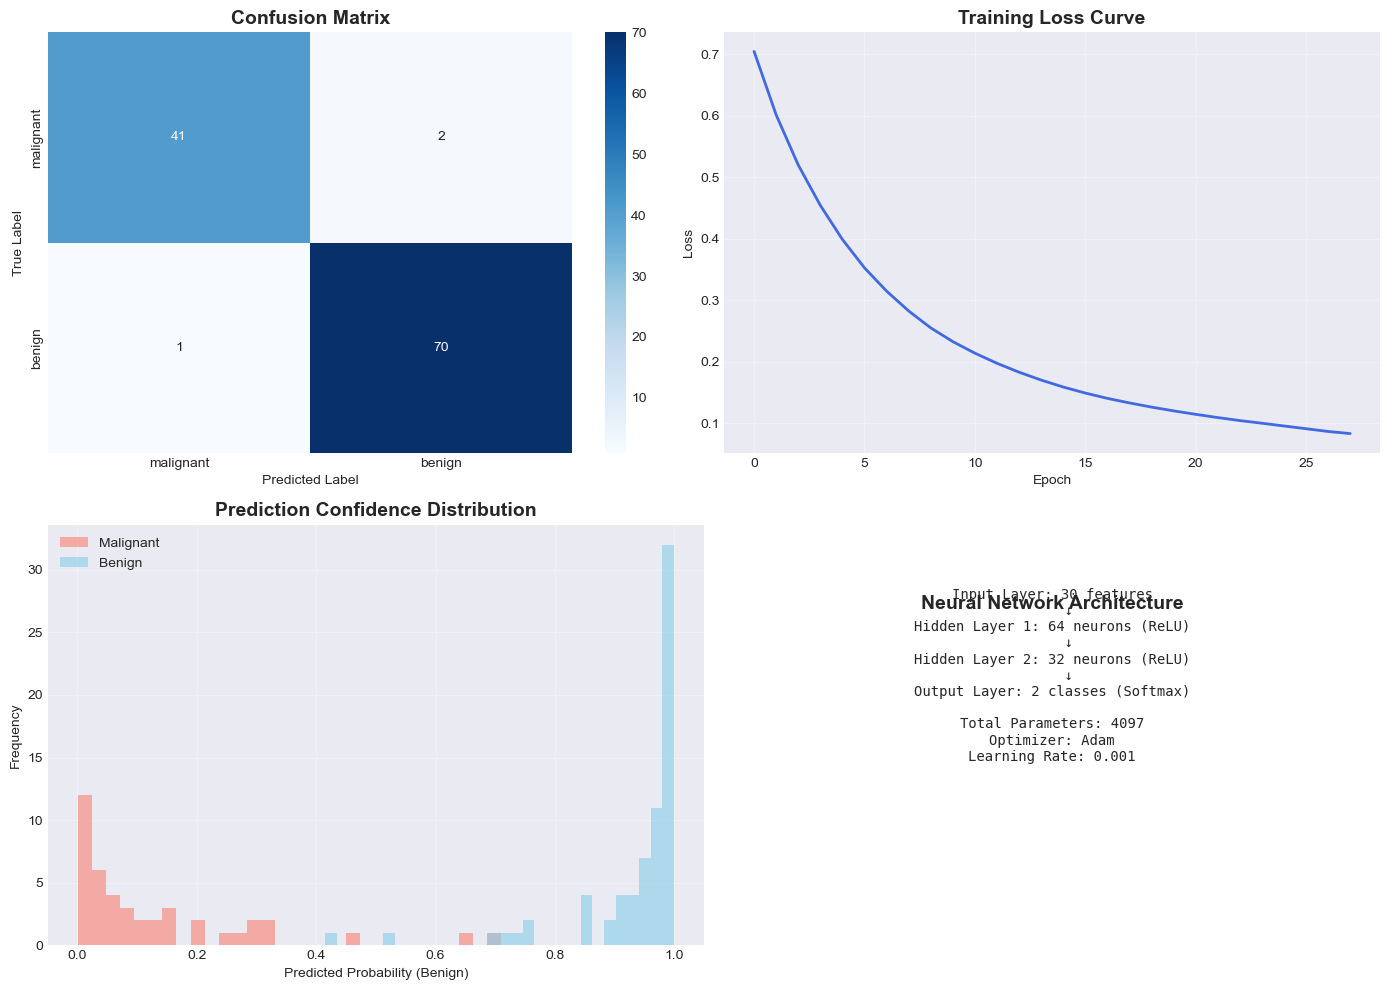

In [10]:
# Visualize results - comprehensive model performance analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix - shows where the model makes correct/incorrect predictions
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=data.target_names, yticklabels=data.target_names)
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. Training Loss Curve - shows how the model learned over time
# Loss should decrease and plateau, indicating convergence
axes[0, 1].plot(mlp.loss_curve_, color='royalblue', linewidth=2)
axes[0, 1].set_title('Training Loss Curve', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction Confidence Distribution - shows how confident the model is
# Good models show clear separation: malignant near 0, benign near 1
y_proba = mlp.predict_proba(X_test_scaled)[:, 1]  # Probability of benign class
axes[1, 0].hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='Malignant', color='salmon')
axes[1, 0].hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Benign', color='skyblue')
axes[1, 0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Probability (Benign)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Model Architecture Visualization - summary of network structure
# Shows the data flow from input through hidden layers to output
axes[1, 1].text(0.5, 0.8, 'Neural Network Architecture', fontsize=14, fontweight='bold',
                ha='center', transform=axes[1, 1].transAxes)
arch_text = f"""
Input Layer: {X.shape[1]} features
    ↓
Hidden Layer 1: 64 neurons (ReLU)
    ↓
Hidden Layer 2: 32 neurons (ReLU)
    ↓
Output Layer: 2 classes (Softmax)

Total Parameters: {sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_)}
Optimizer: Adam
Learning Rate: 0.001
"""
axes[1, 1].text(0.5, 0.4, arch_text, fontsize=10, ha='center', 
                family='monospace', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### 2.4 Comparison: Neural Network vs Traditional ML

Let's compare our neural network with traditional algorithms.


Training comparison models...

Logistic Regression:
  Train: 0.9868 | Test: 0.9737

Decision Tree:
  Train: 1.0000 | Test: 0.9474

Neural Network:
  Train: 0.9604 | Test: 0.9737



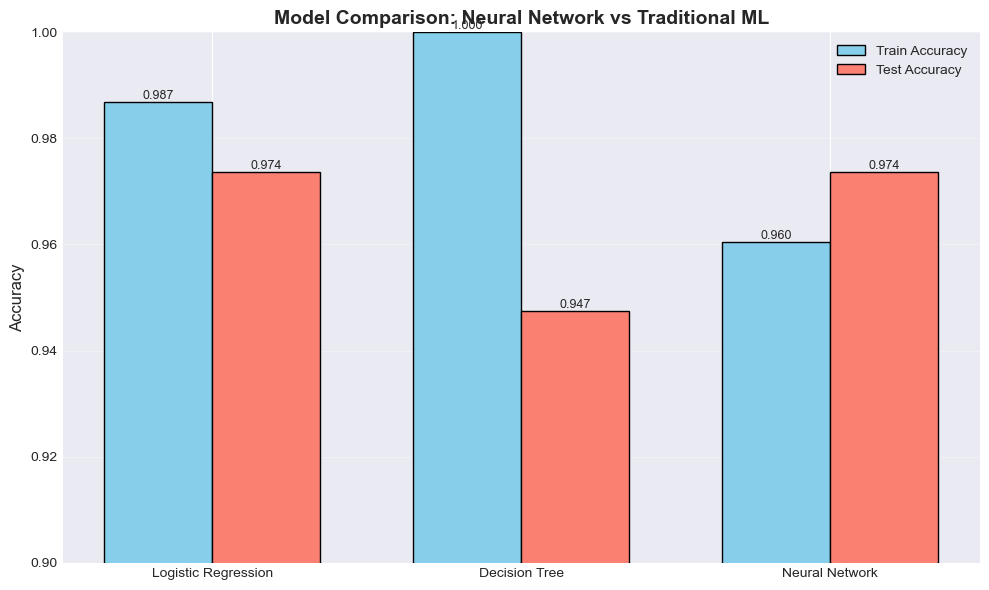

In [11]:
# Train multiple models for comparison - see how neural networks stack up!
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, 
                                     early_stopping=True, random_state=42)
}

results = []

print("Training comparison models...\n")
for name, model in models.items():
    # Train each model on the same scaled data
    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    results.append({
        'Model': name,
        'Train Accuracy': train_score,
        'Test Accuracy': test_score
    })
    print(f"{name}:")
    print(f"  Train: {train_score:.4f} | Test: {test_score:.4f}\n")

# Visualize comparison - side-by-side bar chart
import pandas as pd
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35  # Width of bars

# Create grouped bars for train vs test accuracy
bars1 = ax.bar(x - width/2, results_df['Train Accuracy'], width, 
               label='Train Accuracy', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, results_df['Test Accuracy'], width, 
               label='Test Accuracy', color='salmon', edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Comparison: Neural Network vs Traditional ML', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.9, 1.0)  # Zoom in to see differences more clearly

# Add value labels on bars for precise comparison
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 2.5 Effect of Network Depth

Let's experiment with different architectures to understand the impact of depth.


Testing different network architectures...

Architecture (32,):
  Accuracy: 0.8947 | Params: 1025 | Iterations: 23

Architecture (64, 32):
  Accuracy: 0.9737 | Params: 4097 | Iterations: 28

Architecture (128, 64, 32):
  Accuracy: 0.9649 | Params: 14337 | Iterations: 26

Architecture (256, 128, 64, 32):
  Accuracy: 0.9737 | Params: 51201 | Iterations: 16



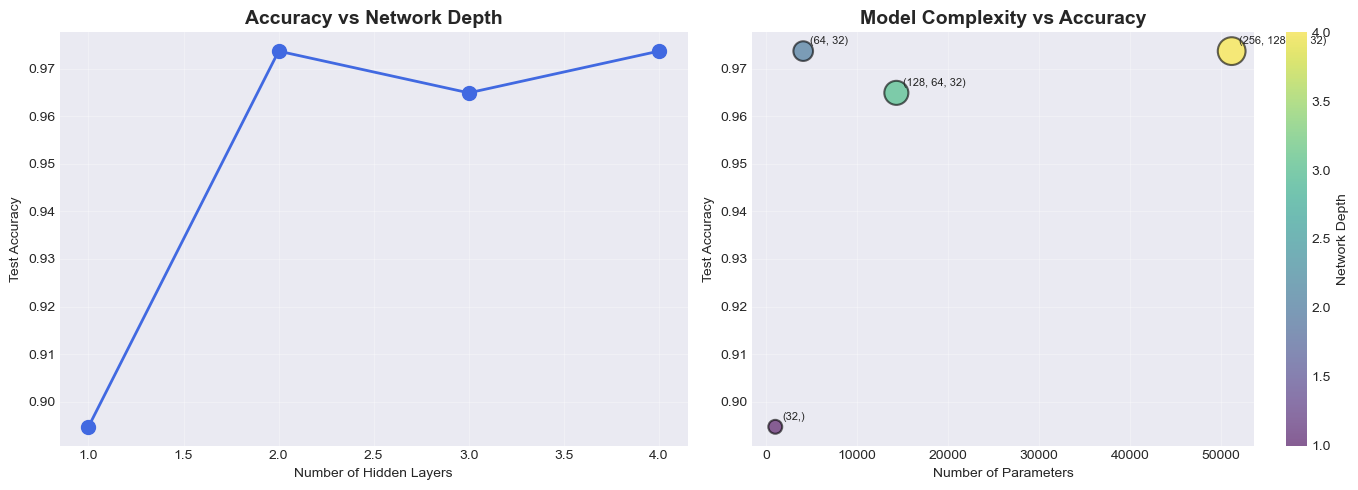

In [12]:
# Test different architectures - does deeper always mean better?
# Experiment with varying network depths to understand the depth-performance relationship
architectures = [
    (32,),           # Shallow: 1 hidden layer (baseline)
    (64, 32),        # Medium: 2 hidden layers (good starting point)
    (128, 64, 32),   # Deep: 3 hidden layers (more capacity)
    (256, 128, 64, 32)  # Very Deep: 4 hidden layers (most complex)
]

arch_results = []

print("Testing different network architectures...\n")
for arch in architectures:
    mlp_arch = MLPClassifier(
        hidden_layer_sizes=arch,
        max_iter=500,
        early_stopping=True,  # Prevents overfitting
        random_state=42,
        verbose=False
    )
    mlp_arch.fit(X_train_scaled, y_train)
    test_score = mlp_arch.score(X_test_scaled, y_test)
    
    # Calculate total trainable parameters (weights + biases)
    n_params = sum(w.size for w in mlp_arch.coefs_) + sum(b.size for b in mlp_arch.intercepts_)
    
    arch_results.append({
        'Architecture': str(arch),
        'Depth': len(arch),
        'Parameters': n_params,
        'Test Accuracy': test_score,
        'Iterations': mlp_arch.n_iter_
    })
    print(f"Architecture {arch}:")
    print(f"  Accuracy: {test_score:.4f} | Params: {n_params} | Iterations: {mlp_arch.n_iter_}\n")

arch_df = pd.DataFrame(arch_results)

# Visualize architecture comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Accuracy vs Depth
# Shows if deeper networks provide better performance
axes[0].plot(arch_df['Depth'], arch_df['Test Accuracy'], 
             marker='o', linewidth=2, markersize=10, color='royalblue')
axes[0].set_title('Accuracy vs Network Depth', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Hidden Layers')
axes[0].set_ylabel('Test Accuracy')
axes[0].grid(True, alpha=0.3)

# Right plot: Parameters vs Accuracy
# Bubble size represents network depth - helps visualize complexity trade-off
scatter = axes[1].scatter(arch_df['Parameters'], arch_df['Test Accuracy'], 
                          s=arch_df['Depth']*100,  # Bubble size = depth
                          alpha=0.6, c=arch_df['Depth'], 
                          cmap='viridis', edgecolors='black', linewidth=1.5)
axes[1].set_title('Model Complexity vs Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Test Accuracy')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Network Depth')

# Annotate each point with its architecture
for idx, row in arch_df.iterrows():
    axes[1].annotate(row['Architecture'], 
                     (row['Parameters'], row['Test Accuracy']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


### Insights on Network Depth:

1. **Diminishing Returns**: Adding more layers doesn't always improve performance
2. **Overfitting Risk**: Deeper networks with more parameters can overfit on small datasets
3. **Start Simple**: Begin with shallow networks and add depth only if needed
4. **Dataset Dependency**: The optimal architecture depends on your specific problem

**Rule of Thumb**: Start with 1-2 hidden layers, use 2-3x the input size for the first hidden layer.

---


## 3. Hands-On Exercise

Now it's your turn to practice! Complete the following exercises to solidify your understanding.

### Exercise 1: Hyperparameter Tuning

**Task**: Experiment with different hyperparameters and find the best configuration.

**Parameters to tune:**
- Learning rate: [0.001, 0.01, 0.1]
- Hidden layer sizes: [(32,), (64, 32), (128, 64, 32)]
- Activation functions: ['relu', 'tanh']

**Hint**: Use a loop to test different combinations and track results.


In [13]:
# Your code here
# TODO: Create a function to test different hyperparameter combinations

def tune_hyperparameters():
    """
    Tune neural network hyperparameters.
    Test different combinations and return the best configuration.
    
    Steps:
    1. Create nested loops for each hyperparameter
    2. Train a model for each combination
    3. Evaluate on validation set
    4. Track the best performing configuration
    5. Return the best config and its score
    """
    # Hyperparameter search space
    learning_rates = [0.001, 0.01, 0.1]
    hidden_layers = [(32,), (64, 32), (128, 64, 32)]
    activations = ['relu', 'tanh']
    
    # Track best configuration
    best_score = 0
    best_config = {}
    
    # TODO: Implement grid search
    # for lr in learning_rates:
    #     for layers in hidden_layers:
    #         for activation in activations:
    #             # Create and train model with these hyperparameters
    #             # Evaluate on validation set
    #             # Update best_config if this is better
    
    # Your implementation here
    pass

# Test your function
# best_config = tune_hyperparameters()
# print(f"Best configuration: {best_config}")


### Exercise 2: Build a Network for Regression

**Task**: Create a neural network for regression instead of classification.

**Dataset**: Use `sklearn.datasets.make_regression` to generate data

**Requirements:**
- Use MLPRegressor (not MLPClassifier)
- Choose appropriate loss function and activation for output layer
- Evaluate using Mean Squared Error (MSE) and R² score

**Hint**: For regression, the output layer typically uses linear activation.


In [14]:
# Your code here
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# TODO: Generate regression data
# X, y = make_regression(n_samples=1000, n_features=10, noise=10, random_state=42)
# Hint: Split into train/test and scale the features!

# TODO: Build and train MLPRegressor
# Key differences from classification:
# - No activation function on output layer (or use 'identity')
# - Output is continuous, not discrete classes
# - Loss function is MSE instead of cross-entropy
# Example:
# mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

# TODO: Evaluate and visualize results
# Use mean_squared_error() and r2_score()
# r2_score ranges from -∞ to 1, where 1 is perfect prediction
# Plot predicted vs actual values to visualize performance


### Exercise 3: Learning Rate Impact

**Task**: Visualize how different learning rates affect training.

**Steps:**
1. Train three models with learning rates: 0.001, 0.01, 0.1
2. Plot their loss curves on the same graph
3. Analyze which converges fastest and which achieves best final loss

**Observation**: What happens with too high or too low learning rate?


In [15]:
# Your code here
# TODO: Train models with different learning rates
# learning_rates = [0.001, 0.01, 0.1]
# 
# Hint: Store each model's loss_curve_ and plot them on the same graph
# plt.plot(model.loss_curve_, label=f'LR={lr}')
#
# Expected observations:
# - Too low (0.001): Slow convergence, many iterations needed
# - Just right (0.01): Smooth convergence to low loss
# - Too high (0.1): Unstable, loss might oscillate or diverge

# TODO: Plot and compare loss curves
# Use different colors for each learning rate
# Add legend to identify which line corresponds to which LR
# Which learning rate converges fastest? Which achieves lowest final loss?


### Exercise 4: Feature Scaling Impact

**Task**: Demonstrate the importance of feature scaling.

**Steps:**
1. Train one model on scaled data
2. Train another on unscaled data
3. Compare training time and final accuracy

**Expected Result**: Scaled data should train faster and achieve better results.


In [16]:
# Your code here
import time

# TODO: Train model on scaled data and measure time
# Example:
# start = time.time()
# mlp_scaled = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
# mlp_scaled.fit(X_train_scaled, y_train)
# scaled_time = time.time() - start
# scaled_accuracy = mlp_scaled.score(X_test_scaled, y_test)
# scaled_iterations = mlp_scaled.n_iter_

# TODO: Train model on unscaled data and measure time
# Use the SAME hyperparameters but train on X_train (not X_train_scaled)
# Track time, accuracy, and number of iterations

# TODO: Compare results
# Create a comparison table or visualization showing:
# - Training time (scaled vs unscaled)
# - Final accuracy (scaled vs unscaled)
# - Number of iterations (scaled vs unscaled)
# - Loss curves side-by-side
#
# Expected result: Scaled data trains faster, converges better, and achieves higher accuracy


---

## 4. Key Takeaways

### Core Concepts Learned:

1. **Neural Network Fundamentals**
   - Neurons, layers, weights, and biases
   - Activation functions introduce non-linearity
   - Deep networks can learn complex patterns

2. **Forward Propagation**
   - Data flows through layers to produce predictions
   - Each layer transforms data: `output = activation(weights × input + bias)`

3. **Backpropagation & Learning**
   - Calculate error at output, propagate backwards
   - Update weights using gradient descent
   - Learning rate controls step size

4. **Practical Guidelines**
   - Always scale features before training
   - Start with simple architectures (1-2 hidden layers)
   - Use ReLU for hidden layers, appropriate activation for output
   - Monitor training loss to detect issues

### When to Use Neural Networks:

**Use Neural Networks:**
- Large datasets (thousands+ samples)
- Complex, non-linear patterns
- Unstructured data (images, text, audio)
- When feature engineering is difficult

**Use Traditional ML:**
- Small datasets (< 1000 samples)
- Interpretability is critical
- Need fast training/inference
- Problem is relatively simple

### Common Pitfalls to Avoid:

1. **Not scaling features** - Neural networks need normalized inputs
2. **Starting too complex** - Begin simple, add complexity if needed
3. **Wrong learning rate** - Too high = unstable, too low = slow
4. **Ignoring overfitting** - Use validation sets and early stopping
5. **Not enough data** - Neural networks need substantial data to generalize

---


## 5. Next Steps & Further Learning

### Tomorrow (Day 16): Building Neural Networks with PyTorch

We'll transition from scikit-learn to PyTorch, the industry-standard deep learning framework. You'll learn:
- PyTorch tensors and automatic differentiation
- Building custom neural network architectures
- Training loops and optimization
- GPU acceleration

### Recommended Resources:

**Interactive Learning:**
- [Neural Network Playground](http://playground.tensorflow.org/) - Visualize how networks learn
- [3Blue1Brown: Neural Networks](https://www.youtube.com/watch?v=aircAruvnKk) - Beautiful visual explanations

**Documentation:**
- [Scikit-learn Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
- [PyTorch Tutorials](https://pytorch.org/tutorials/)

**Books:**
- "Deep Learning" by Ian Goodfellow (free online)
- "Neural Networks and Deep Learning" by Michael Nielsen (free online)

### Practice Projects:

1. **MNIST Digit Classification** - Classic beginner project
2. **Wine Quality Prediction** - Regression with neural networks
3. **Credit Card Fraud Detection** - Imbalanced classification

### Self-Study Questions:

1. Why do we need activation functions? What happens without them?
2. How does backpropagation differ from forward propagation?
3. What's the relationship between learning rate and convergence?
4. When would you choose a shallow vs deep network?
5. Why is feature scaling crucial for neural networks?

---

### Checklist for Today:

- [ ] Understand neural network architecture (layers, neurons, weights)
- [ ] Grasp forward and backward propagation concepts
- [ ] Implement a simple neural network from scratch
- [ ] Use scikit-learn's MLPClassifier on real data
- [ ] Compare neural networks with traditional ML algorithms
- [ ] Complete at least 2 hands-on exercises
- [ ] Experiment with different architectures and hyperparameters

---

**Congratulations on completing Day 15!** You now have a solid foundation in neural networks. Tomorrow, we'll dive deeper into PyTorch and start building more sophisticated models.

*Remember: Understanding comes from implementation. Don't just read the code—run it, modify it, break it, and fix it. That's how you truly learn.*
